In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли

Загружаем датасет

In [2]:
df = pd.read_csv("C:\IDE\Project_Estate\data.csv")

In [3]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Предварительный анализ данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [5]:
df.isnull().sum().sum()

1869151

In [6]:
!pip install flatten_json


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import ast
import json
from flatten_json import flatten

Разбираем список json в признаке 'homeFacts'

In [8]:
df['homeFacts'] = df['homeFacts'].apply(lambda a: ast.literal_eval(a))

In [9]:
homeFacts = df['homeFacts'].apply(flatten).apply(pd.Series)

In [10]:
homeFacts = homeFacts.rename(columns = {'atAGlanceFacts_0_factValue' : 'Year built',
                            'atAGlanceFacts_1_factValue' : 'Remodeled year', 
                            'atAGlanceFacts_2_factValue' : 'Heating', 
                            'atAGlanceFacts_3_factValue' : 'Cooling',
                            'atAGlanceFacts_4_factValue' : 'Parking',
                            'atAGlanceFacts_5_factValue' : 'lotsize',
                            'atAGlanceFacts_6_factValue' : 'Price/sqft'})
homeFacts = homeFacts.drop(['atAGlanceFacts_0_factLabel',
                'atAGlanceFacts_1_factLabel',
                'atAGlanceFacts_2_factLabel',
                'atAGlanceFacts_3_factLabel',
                'atAGlanceFacts_4_factLabel',
                'atAGlanceFacts_5_factLabel',
                'atAGlanceFacts_6_factLabel'], axis=1)

Прибавляем дополнительные столбцы которые были зашиты в признаке homeFacts. Удаляем данный признак из датасета

In [11]:
df = pd.concat([df,homeFacts], axis=1)
df = df.drop(['homeFacts'],axis=1)

In [12]:
'''df['schools'] = df['schools'].apply(ast.literal_eval)
schools = pd.json_normalize(
    df['schools'],
    errors='ignore'
)
schools[0].apply(flatten).apply(pd.Series)'''

"df['schools'] = df['schools'].apply(ast.literal_eval)\nschools = pd.json_normalize(\n    df['schools'],\n    errors='ignore'\n)\nschools[0].apply(flatten).apply(pd.Series)"

In [13]:
df.describe()

,status,private pool,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,...,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
count,337267,4181,342452,377183,270847,103115,377151,377185,336608,377185,...,40311,310305,374704,373572,350616,373652,373652,373652,348797,318632
unique,159,1,1280,337076,229,1653,2026,297365,25405,4549,...,2,232944,43939,230,154,1984,1445,3346,37393,6504
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,...,yes,NO MLS,"$225,000",,,,Central,,,
freq,156104,4181,92206,672,52466,50356,24442,4204,11854,2141,...,28793,24,1462,58761,199541,105799,158754,171887,33067,5185


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   status          337267 non-null  object
 1   private pool    4181 non-null    object
 2   propertyType    342452 non-null  object
 3   street          377183 non-null  object
 4   baths           270847 non-null  object
 5   fireplace       103115 non-null  object
 6   city            377151 non-null  object
 7   schools         377185 non-null  object
 8   sqft            336608 non-null  object
 9   zipcode         377185 non-null  object
 10  beds            285903 non-null  object
 11  state           377185 non-null  object
 12  stories         226470 non-null  object
 13  mls-id          24942 non-null   object
 14  PrivatePool     40311 non-null   object
 15  MlsId           310305 non-null  object
 16  target          374704 non-null  object
 17  Year built      373572 non-nu

In [15]:
df_new = df.copy()

In [16]:
df_new.head()

,status,private pool,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,...,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,...,NaN,611019,"$418,000",2019,,"Central A/C, Heat Pump",,,None,$144
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,...,NaN,201916904,"$310,000",2019,,,,,5828 sqft,$159/sqft
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,...,yes,FR19221027,"$2,895,000",1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,...,NaN,14191809,"$2,395,000",2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,...,NaN,861745,"$5,000",,,,,,"10,019 sqft",None


Начинаем работу с признаками по очищению их от повторений, различного написания и прочего.

Укрупняем позиции по признаку propertyType.

In [17]:
def propertyType(arg):
    if arg in ['single-family home', 'Single Family Home', 'Single Family']:
        return 'single-family'
    elif arg in ['Detached, One Story', 'Single Detached, Traditional', '1 Story', 'Single Detached','One Story']:
        return 'cabin'
    elif arg in ['manufactured home (house)', 'mobile', 'prefab', 'modular', 'mo2 le', 'mo2le', 'mobile/manufactured','Mobile / Manufactured','Mfd/Mobile Home']:
        return 'mobile'
    elif arg in ['cabin', 'ca2 n', 'ca2n']:
        return 'cabin'
    elif arg in ['midcentury', 'mid century' ,'mid-century']:
        return 'midcentury'
    elif arg in ['Townhouse', 'townhouse','townhome', 'Townhome']:
        return 'townhouse'
    elif arg in ['Condo', 'condo']:
        return 'condo'
    elif arg in ['Multi-Family Home', 'multi-family', 'Multi Family', 'Multi-Family Home']:
        return 'multi-family'
    elif arg in ['Contemporary', 'Contemporary/Modern', 'Multi Family']:
        return 'contemporary'
    elif arg in ['Land', 'lot/land']:
        return 'lot/land'
    elif arg in ['2 Stories', 'Detached, Two Story','Two Story','2 Story']:
        return '2 Stories'
    else:
        return arg

In [18]:
df_new['propertyType'] = df_new['propertyType'].apply(propertyType)

Оставляем только первые 35 наиболее чато встречающихся значений, остальные кодируем как 'Other'

In [19]:
cols_lst = df_new['propertyType'].value_counts().head(35).index

In [20]:
def proptype_unzip(arg):
    if arg in cols_lst:
        return arg
    else:
        return 'other'

In [21]:
df_new['propertyType'] = df_new['propertyType'].apply(proptype_unzip)

Обрабатываем признак PrivatePool. Объединяем его с дублирующим признаком private pool и удаем его из df.
Там где стоит слово yes - кодируем 1, там где пропуски - ставим 0.

In [22]:
df_new['PrivatePool'].value_counts()

yes    28793
Yes    11518
Name: PrivatePool, dtype: int64

In [23]:
df_new['PrivatePool'] = df_new['PrivatePool'].fillna(df_new['private pool'])
df_new = df_new.drop(['private pool'], axis=1)

In [24]:
df_new['PrivatePool'] = df_new['PrivatePool'].apply(lambda x: 'yes' if x == 'Yes' else x )
df_new['PrivatePool'] = df_new['PrivatePool'].apply(lambda x: 1 if x == 'yes' else 0 )

Разбираем признак baths. Убираем некорректно занесенные данные , там где данные числовые плюс слово Bath, ba и пр оставляем только число. В местах где значения некорректные осталяем значение 0.

In [25]:
def bathnum(arg):
    if type(arg) == str:
        if arg in ['~', 'nan', '—', '--','-- ba','-- Baths', '-- baths', '0', '0 / 0', 'Sq. Ft. ', '0.00', '0.0', 'Sq. Ft.',
                   '1-0 / 1-0 / 1', '1-0 / 1-0 / 1', '3-1 / 2-2', '1 / 1 / 1 / 1', '1 / 1-0 / 1-0 / 1-0',
                   '2-1 / 2-1 / 1-1 / 1-1', 'SemiMod', '116 / 116 / 116','1-2','Bathrooms: SemiMod','1-2 Baths']:
            return 0
        elif arg[-1] == '+':
            return arg[:-1]
        else:
            wrds_list = arg.split()
            if len(wrds_list) == 1:
                return wrds_list[0]
            elif wrds_list[1] in ['ba', 'Baths', 'baths']:
               return wrds_list[0]
            elif wrds_list[0] in ['Bathrooms:']:
                return wrds_list[1]
            else:
                return arg
    elif arg in ['~', 'nan', '—', '--', '0', '0 / 0', 'Sq. Ft. ', '0.00', '0.0', 'Sq. Ft.','SemiMod']:
        return 0
    elif arg in ['1-0 / 1-0 / 1', '1-0 / 1-0 / 1', '3-1 / 2-2', '1 / 1 / 1 / 1', '1 / 1-0 / 1-0 / 1-0', '2-1 / 2-1 / 1-1 / 1-1', 'SemiMod', '116 / 116 / 116','1-2']:
        return 0
    else:   
        return arg

In [26]:
df_new['baths'] = df_new['baths'].apply(bathnum)

In [27]:
df_new['baths'] = df_new['baths'].str.replace(',','.')
df_new['baths'] = df_new['baths'].astype('float')

Разбираем признак sqft. Убираем некорректно занесенные данные , там где данные числовые плюс слово sqft оставляем только число. Числовые значения с ',' преобразуем в числа. В местах где значения некорректные осталяем значение 0.

In [28]:
def sqftres(arg):
    if type(arg) == str:
        wrds_list = arg.split()
        if arg in ['—','--','610-840','610-840 sqft', '-- sqft']:
            return 0        
        elif len(wrds_list) == 1:
            return wrds_list[0]
        elif wrds_list[1] in ['sqft']:
            return wrds_list[0]
        elif wrds_list[-1] == 'sqft':
            return wrds_list[-2]
    else:
        return arg

In [29]:
df_new['sqft'] = df_new['sqft'].apply(sqftres)

In [30]:
df_new['sqft'] = df_new['sqft'].str.replace(',','')
df_new['sqft'] = df_new['sqft'].astype('float')

Разбираем признак fireplace. там где есть хоть какое то упоминание про наличие соотвествующего инвенторя - ставим значение 1. В местах где значений нет осталяем значение 0.

In [31]:
def fireplace(arg):
    if arg in ['Yes', '1', '2', 'Great Room','Fireplace','Gas Logs, Great Room','Living Room', 'Fireplace YN',
               'Fireplace Features','FAMILYRM','1 Fireplace','Gas/Gas Logs', 'Wood Burning',
               'FAMILYRM, Gas Logs', 'Gas Logs, In Great Room', 'Gas Logs','1 Fireplace, Fireplace Living Rm',
               'Wood', 'Special Features', 'Gas Log, One', 'Gas Logs, In Living Room', 'Gas', 'Gas Logs, Living Room',
               'Gas Logs, In Den/Family Room', 'Living Room, Wood Burning', 'One', '1 Fireplace, Fireplace Family Rm',
               'Fireplaces - Woodburning', '# Fireplaces - Gas', 'Log Woodburning, One', 'Electric', 'Family Room',
               'Family Room, Wood Burning', 'In Living Room', 'Gas Fuel,LOCATION', 'Fireplace-Gas, Forced Air','FAMILYRM, Wood Burning',
               '1 Fireplace, Gas Fireplace','Fireplace-Wood, Forced Air', 'Gas, One', 'Gas Vented, Great Room',
               '# Fireplaces - Woodburning','1 Fireplace, Fireplace Family Rm, Gas Fireplace','FAMILYRM, Gas Vented',
               'FAMILYRM, Gas Logs, Gas Vented','Fireplaces', 'Firepit', 'Fire Pit,LOCATION', 'In Living Room, Wood Burning', 'FAMILYRM, Natural Gas',
               'Fire Pit,LOCATION','Gas Fuel','3','4', '5','1 Fireplace, Fireplace Living Rm, Gas Fireplace', 'Gas, Family Room','Great Room, Wood Burning',
               'Gas Logs, Gas Vented, Great Room','Gas Fireplace', 'One, Wood Burning', '1 Fireplace, Fireplace Living Rm, Gas Fireplace', 'In Great Room',
               '1 Fireplace, Wood Burning Frplc','Gas Log Starter, Gas Logs, In Great Room','Wood Burning, Gas Starter','Gas Log' ]:
        return 'yes'
    else:
        return 'no'

In [32]:
df_new['fireplace'] = df_new['fireplace'].apply(fireplace)
df_new['fireplace'] = df_new['fireplace'].apply(lambda x: 1 if x == 'yes' else 0)

Разбираем признак beds. Убираем некорректно занесенные данные , там где данные числовые плюс слово beds оставляем только число. В местах где значения некорректные осталяем значение 0.

In [33]:
def beds(arg):
    if arg in ['--', 'Baths', '1,960 sqft','bd','Beds','Bath','2,178', '2,178 bd','2,178 Beds', 
               '-- bd', '-- Beds','2,178 sqft','8,637','8,637 bd','10,310 bd','Based','Based bd','Based Beds', '1-2', '1-2 bd','1-2 Beds','#',
               '1 Bath, 2 Bedrooms, Living Room, Range/Oven, Refrigerator','1 Bath, 2 Bedrooms',
               "Based on Redfin's St Johns data, we estimate the home's value is $360,731, which is 2.2% less than its current list price.",
               '1 Bath, 2 Bedrooms, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator',
               '3 or More Bedrooms, Dining Room, Living Room, Range/Oven, Refrigerator',
               '1 Bath, 3 or More Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator',
               "Based on Redfin's Raleigh data, we estimate the home's value is $708,248, which is 1.2% more than its current list price.",
               '2 Baths, 3 or More Bedrooms','3 or More Bedrooms','1 Bath, 2 Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room',
               '# Bedrooms 1st Floor']:
        return 0
    if type(arg) == str:
        wrds_list = arg.split()
        if len(wrds_list) == 0:
            return 0
        elif len(wrds_list) == 1:
            return wrds_list[0]
        elif (len(wrds_list) > 1) & (wrds_list[1] in ['bd', 'Beds']):
            return wrds_list[0]
        elif wrds_list[-1] in ['acres','sqft', 'Acre','acre','Sqft','Sq.']:
            return 0
        else:
            return arg
    else:
        return arg

In [34]:
df_new['beds'] = df_new['beds'].apply(beds)
df_new['beds'] = df_new['beds'].astype('float')

Разбираем признак stories. Укрупняем группы с некорректно занесенные данные, формируем 5 группы (1,1.5,2,3 эатажа и более). В местах где значения некорректные осталяем значение 0.

In [35]:
def stories(arg):
    if arg in ['1','1.0','1.00','1.0000','1.000','One','One Level', '1 Story', 'One Story', '1 Level','Ranch/1 Story','1 Story/Ranch','1 Story/F.R.O.G.',
               'Ground Level, One','1 Story, Multi Level','1 Story, Hillside','1 Story, Townhouse','1 Story Basement',
               '1 Story, Townhouse',', 1','1 Story, Split Level','1, 1']:
        return 1
    elif arg in ['2.0','2','2.00','Bi-Level','Split Entry (Bi-Level)','2.0000',', 2','2 Stories, Townhouse','2 Story', '2 Story/Basement','2 Stories, Townhouse','2 Stories','Ground Level, Two',
                 'Ground Level, Split Level, Two','Two','2 Levels','2 Stories, Tear Down','2 Story, Tri Level',
                 'Two, Multi/Split','2 Story, Split Level','Double Wide']:
        return 2
    elif arg in ['1.5','1.50','1.5000','1.5 Stories','1.5 Story/Basement', 'One and One Half','1 1/2 Levels',
                 '1 1/2 Story','1.5 Story','1.500']:
        return 1.5
    elif arg in ['3','3.0','3.00','3.000','3.0000','Tri-Level','3 Stories','3+ Story','3 Story, Multi Level','Multi Level, Tri Level',
                 '3 Story','3 Story, Tri Level','3 Levels','Tri Level','Tri/Multi Level','3 Story/Basement','Tri/Multi Level']:
        return 3
    elif arg in ['3+','4.0','Three Or More', '4 Story','3+ Story','6+ Stories','Three Or More Levels',
             '3 - 5 Stories','Multi Level, Three or More','Condo 5+ Stories',]:
        return '3+'
    elif arg in ['0','0.0']:
        return np.nan
    else:
        return arg

In [36]:
def storiesnum(arg):
    if (type(arg) == float) & (type(arg)== int):
        return arg
    elif type(arg) == str:
        if re.search(r'\d+', arg ) is None:
            return 'other'
        else:
            num_st = int(re.search(r'\d+', arg )[0])
            if num_st > 3:
                return '3+'
            elif num_st <= 3:
                return num_st
    else:
        return arg

In [37]:
df_new['stories'] = df_new['stories'].apply(stories)
df_new['stories'] = df_new['stories'].apply(storiesnum)

Год постройки и год последнего ремонта преобразуем в признаки Age возраст постройки и last_repair -  кол-во лет с последнего ремонта. Удаляем записи с аномальными значениями года постройки.

In [38]:
df_new['Year built'] = df_new['Year built'].str.extract('([-+]?\d*\.?\d+)')
df_new['Year built'] = df_new['Year built'].apply(pd.to_numeric)
df_new['Remodeled year'] = df_new['Remodeled year'].str.extract('([-+]?\d*\.?\d+)')
df_new['Remodeled year'] = df_new['Remodeled year'].apply(pd.to_numeric)
df_new = df_new[(df_new['Year built'] > 1787) & (df_new['Year built'] < 2023)]
df_new['Remodeled year']= df_new['Remodeled year'].fillna(0)

In [39]:
df_new['Age'] = 2023 - df_new['Year built']

In [40]:
def last_repair(row):
    if row['Remodeled year'] == 0:
        row['Remodeled year'] = row['Year built']
    return 2023 - row['Remodeled year']

In [41]:
df_new['Repaired'] = df_new['Remodeled year'].apply(lambda x: 1 if x>0 else 0)
df_new['last_repair'] = df_new.apply(lambda row: last_repair(row), axis=1)
df_new = df_new.drop(['Year built','Remodeled year'], axis=1)

Разбираем признак Heating. Укрупняем группы с некорректно занесенные данные, формируем 5 группы (Forced air, Central, Electric, Gas, Heat pump). В местах где значения некорректные оставляем значение 0.

In [42]:
def Heating(arg):
    if arg in ['Forced Air','Forced Air Heating','Hot Air','Forced air, Other','Forced air, Stove','Baseboard, Forced air',
               'Forced air, Wall','Forced Warm Air','Forced air, Radiant','Electric, Forced Air','ForcedAir']:
        return 'Forced air'
    elif arg in ['Central Electric','Central, Electric','Central Electric, Heat Pump','Central Air','Central Furnace','Central Heating','Central Gas','Central Electric, Zoned',
                'Central Air Conditioning','Central Air, Central Heat','Central Air, Ceiling Fan(s)','Central, Gas',
                'Central, Gas, Two or More Units','Central, Heat Pump','Central, Electric, Heat Pump','Central, Natural Gas',
                'Gas Gas','Central Heating, Electric Source','Central, Electric, Two or More Units','Central Electric, Central Gas',
                'Central, Electric, Gas']:
        return 'Central'
    elif arg in ['Electric Heat', 'Electric Hot Air',', Electric Hot Air']:
        return 'Electric'
    elif arg in [', Gas Hot Air/Furnace','Gas Heat','Natural Gas Heat','Gas Hot Air/Furnace','Forced Air, Gas',
                'Forced Air, Natural Gas',', Gas Hot Air/Furnace, MultiZone Heat','Natural Gas',', Gas Hot Air/Furnace, Gas Water Heater',
                'Forced Air - Gas',', Gas Hot Air/Furnace, Natural Gas',', Natural Gas']:
        return 'Gas'
    elif arg in ['Heat Pump','Forced air, Heat pump',', Heat Pump - Heat','Heat Pump(s)','Forced air, Heat pump, Stove',
                'Electric, Heat Pump','Heat pump, Other']:
        return 'Heat pump'
    elif arg in ['No Data']:
        return 
    else:
        return arg

In [43]:
def Heatingtype(arg):
    if arg in ['Forced air', '','Central','Heat pump','Gas', 'Electric']:
        return arg
    else:
        return 'Other'

In [44]:
df_new['Heating'] = df_new['Heating'].apply(Heating)
df_new['Heating'] = df_new['Heating'].apply(Heatingtype)

Разбираем признак Cooling. там где есть хоть какое то упоминание про наличие соотвествующего оборудования - ставим значение 1. В местах где значений нет осталяем значение 0.

In [45]:
def Cooling(arg):
    if arg in ['No Data', '','None']:
        return 0
    else:
        return 1

In [46]:
df_new['Cooling'] = df_new['Cooling'].apply(Cooling)

Разбираем признак Heating. Укрупняем группы с некорректно занесенные данные, формируем 7 групп ('Attached Garage', '2 spaces', '1 space', 'Detached Garage', 'Carport', '3 spaces', 'Off Street'). В местах где значения некорректные оставляем значение 0.

In [47]:
def Parking(arg):
    if arg in ['2']:
        return '2 spaces'
    elif arg in ['Off Street, Attached Garage','Attached - REAR','Attached Garage, Garage - 2 Car',
                 'Garage Attached','Attached - SIDE, AGGRE','2 Car Garage, Attached Garage, Opener',
                'Attached Garage, Driveway','Attached - FRONT','Attached Garage, Driveway, Garage - 2 Car']:
        return 'Attached Garage'
    elif arg in ['1']:
        return '1 space'
    elif arg in ['Carport, Attached Garage','Attached Garage, Carport','Carport, Detached Garage',
                'Off Street, Carport','Carport Spaces']:
        return 'Carport'
    elif arg in ['Off street','Off street parking']:
        return 'Off Street'
    elif arg in ['Detached Garage, Attached Garage']:
        return 'Attached Garage, Detached Garage'
    elif arg in ['3']:
        return '3 spaces'
    elif arg in ['4']:
        return '4 spaces'
    elif arg in ['No Data','None','0']:
        return None
    else:
        return arg

In [48]:
def Parkingnum(arg):
    if arg in ['Attached Garage', '','2 spaces','1 space','Detached Garage', 'Carport','3 spaces','Off Street']:
        return arg
    else:
        return 'Other'

In [49]:
df_new['Parking'] = df_new['Parking'].apply(Parking)
df_new['Parking'] = df_new['Parking'].apply(Parkingnum)

Разбираем признак lotsize. Некорректно занесенным данным присваиваем 0. Остальные значения преобразуем ',' заменяя на пустоту. Перевоим признак в число, с учетом того, что есть значения в акрах - умножаем его на 43560 для перевода в квадратные футы 

In [50]:
def lotsize(arg):
    if arg in ['2', '2 spaces']:
        return None
    elif arg in ['No Data','—','-- sqft lot']:
        return None
    else:
        return arg

In [51]:
df_new['lotsize'] = df_new['lotsize'].apply(lotsize)

In [52]:
df_new['lotsize'] = df_new['lotsize'].str.replace(',','')

In [53]:
def lotsizesqft(arg):
    if arg == '':
        return None
    if type(arg) == str:
        wrds_list = arg.split()
        if len(wrds_list) == 1:
            return arg
        elif wrds_list[1] in ['acres','Acres','acre','Acre']:
            return 43560*float(wrds_list[0])
        elif wrds_list[1] in ['sqft','Sq.']:
            return wrds_list[0]
        else:
            return arg
    else:
        return arg

In [54]:
df_new['lotsize'] = df_new['lotsize'].apply(lotsizesqft)
df_new['lotsize'] = df_new['lotsize'].astype('float')

Разбираем признак status. Укрупняем группы с некорректно занесенные данные.

In [55]:
def status(arg):
    if arg in ['For sale']:
        return 'for sale'
    elif arg in ['Pre-foreclosure / auction']:
        return 'Pre-foreclosure'
    elif arg in ['Under Contract   Showing','Under Contract','Active Under Contract']:
        return 'Under Contract Show'
    elif arg in [' / auction']:
        return 'Auction'
    elif arg in ['Foreclosed','Foreclosure']:
        return 'foreclosure'
    elif arg in ['A Active']:
        return 'Active'
    else:
        return arg

In [56]:
df_new['status'] = df_new['status'].apply(status)

Разбираем признак target. Переводим $ в числовой признак.

In [57]:
def target(arg):
    if type(arg) == str:
        if (arg[0] == '$') & (arg[-1] == '+'):
            return arg[1:-1]
        elif (arg[0] == '$') & (arg[-3:] == '/mo'):
            return 0
        elif arg[0] == '$':
            return arg[1:]
        elif arg[-1] == '+':
            return arg[:-1]
        elif arg[-3:] == '/mo':
            return 0
        else:
            return arg
    else:
        return arg

In [58]:
df_new['target'] = df_new['target'].str.replace(',','')
df_new.target = df_new.target.apply(target)
df_new.target = df_new.target.astype('float')

In [59]:
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop_duplicates()
df_new = df_new.drop(index=df_new[df_new['lotsize'] < 0].index[0], axis=0)

In [60]:
df_new_1 = df_new.copy()

Разбираем признак MlsId. Убираем некорректные данные, дополняем признак дублирующимся mls-id, 

In [61]:
def MlsId(arg):
  if arg in ['NO MLS', 'No MLS #', ' A, Houston, TX 77008', 'No ',
       ' 12A, Orlando, FL 32833', ' B, Houston, TX 77008', 'No mls',
       ' 1, South Boston, MA 02127', ' 11A, Orlando, FL 32833',
       ' B, Houston, TX 77007', ' 2, Washington, DC 20002',
       ' 1, Washington, DC 20002', ' 2, Washington, DC 20010', '2101941',
       ' 3A, Orlando, FL 32833', ' 2, Washington, DC 20009',
       'No MLS', ' 0, Doral, FL 33178', ' 1, Washington, DC 20001',
       ' A, Austin, TX 78721', ' 1A, Orlando, FL 32833', 'NOMLSID',
       ' A, Austin, TX 78704', ' 2, Boston, MA 02129',
       ' 2, Washington, DC 20001', ' 1, Washington, DC 20010',
       ' A, Houston, TX 77018', ' A, Houston, TX 77057', ' 1, Washington, DC 20009',
       ' C, Houston, TX 77007',' 0, Medley, FL 33178',' 1, Austin, TX 78702',' 2, Orlando, FL 32835',
       ' 4, Washington, DC 20009',' 2, Washington, DC 20011',' B, Houston, TX 77054',' B, Houston, TX 77018',
       ' D, Houston, TX 77008',' 1, Boston, MA 02125',' 601, Fort Lauderdale, FL 33304',' B, Austin, TX 78721',
       ' 2, Orlando, FL 32822',' A, Austin, TX 78702',' B, Houston, TX 77057',' A, Austin, TX 78723',
       ' C, Houston, TX 77008',' A, Seattle, WA 98103', '1539721',' B, Austin, TX 78704',' B, Austin, TX 78751']:
       return 'NO MLS'
  else:
    return arg

In [62]:
df_new_1['MlsId'] = df_new_1['MlsId'].fillna(df_new_1['mls-id'])

In [63]:
df_new_1['MlsId'] = df_new_1['MlsId'].apply(MlsId)

В признаке город - 1830 значений, оставляем только перые 150 наиболее часто встречающиеся в датасете, остальные заполняем признаком 'other'

In [64]:
city_list = list(df_new_1['city'].value_counts().head(150).index)

In [65]:
def citynum(arg):
    if arg in city_list:
        return arg
    else:
        return 'other'

In [66]:
df_new_1['city'] = df_new_1['city'].apply(citynum)

В признаке возраст здания и последний год ремонта - есть неточности, есть значения где время прошедшее с ремонта больше возраста дома. Предполагаем, это ошибка ручного ввода, менем их местами.

In [67]:
def reversage(row1,row2):
    if row2 > row1:
        return row2
    else:
        return row1

Очищаем данные. Оставляем только данные с ванными комнатами и спальнями менее 20, берем только строки где определена целевая переменная "target", не берем значения где не определен город в котором находится недвижимость. Убираем дубликаты с одинковыми индексами, адресами и MlsId.

In [68]:
df_new_1 = df_new_1[df_new_1['baths'] < 20]
df_new_1 = df_new_1[df_new_1['beds'] < 20]
df_new_1 = df_new_1[~df_new_1.target.isnull()]
df_new_1['Age'] = df_new_1.apply(lambda x: reversage(x['Age'], x['last_repair']), axis=1)
df_new_1 = df_new_1[df_new_1['city'].isnull() != True]
df_new_1 = df_new_1[~df_new_1.duplicated(['MlsId', 'zipcode','street'])]

In [69]:
df_new_1.shape

(215772, 24)

In [70]:
df_new_1.head()

,status,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,beds,...,MlsId,target,Heating,Cooling,Parking,lotsize,Price/sqft,Age,Repaired,last_repair
0,Active,single-family,240 Heather Ln,3.5,1,other,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.0,28387,4.0,...,611019,418000.0,Other,0,,NaN,$144,4.0,0,4.0
1,for sale,single-family,12911 E Heroy Ave,3.0,0,other,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947.0,99216,3.0,...,201916904,310000.0,,0,,5828.0,$159/sqft,4.0,0,4.0
2,for sale,single-family,2005 Westridge Rd,2.0,0,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000.0,90049,3.0,...,FR19221027,2895000.0,Forced air,1,Attached Garage,8626.0,$965/sqft,62.0,1,56.0
3,for sale,single-family,4311 Livingston Ave,8.0,0,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457.0,75205,5.0,...,14191809,2395000.0,Forced air,1,Detached Garage,8220.0,$371/sqft,17.0,1,17.0
7,Active,single-family,11182 Owl Ave,2.0,0,other,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588.0,50401,3.0,...,190988,244900.0,Forced air,1,,124582.0,$68,53.0,0,53.0


Удаляем ненужные признаки, проводим анализ, дозаполняем пропуски.

In [71]:
df_new_1 = df_new_1.drop(['street','schools','zipcode','Price/sqft','mls-id','MlsId','lotsize'], axis=1)

In [72]:
df_new_1.describe().T

,count,mean,std,min,25%,50%,75%,max
baths,215772.0,2.708489,1.295318e+00,0.75,2.0,2.0,3.0,19.0
fireplace,215772.0,0.144815,3.519149e-01,0.00,0.0,0.0,0.0,1.0
sqft,213515.0,6177.021296,1.722632e+06,0.00,1344.0,1856.0,2626.0,795979430.0
beds,215772.0,3.136195,1.484181e+00,0.00,2.0,3.0,4.0,19.0
PrivatePool,215772.0,0.152999,3.599878e-01,0.00,0.0,0.0,0.0,1.0
target,215772.0,670584.548273,1.772078e+06,0.00,219900.0,349000.0,610792.5,195000000.0
Cooling,215772.0,0.760228,4.269450e-01,0.00,1.0,1.0,1.0,1.0
Age,215772.0,41.431395,3.298229e+01,1.00,16.0,35.0,63.0,285.0
Repaired,215772.0,0.446017,4.970785e-01,0.00,0.0,0.0,1.0,1.0
last_repair,215772.0,37.200795,3.092556e+01,1.00,14.0,29.0,54.0,285.0


In [73]:
df_new_1['stories'] = df_new_1['stories'].fillna('')
df_new_1['status'] = df_new_1['status'].fillna('')
df_new_1.stories = df_new_1.stories.astype('str')

In [74]:
df_new_1.describe(include='object').T

,count,unique,top,freq
status,215772,131,for sale,126549
propertyType,215772,35,single-family,136654
city,215772,148,other,47629
state,215772,34,FL,63453
stories,215772,7,,68231
Heating,215772,7,Forced air,105140
Parking,215772,9,,57584


In [75]:
df_new_1.shape

(215772, 17)

Осставляем в признаки status только первые 7 наиболее часто встречающихся

In [76]:
def stutusnum(arg):
    if arg in ['for sale','Active','Pending','Under Contract Show','New construction','Auction','Contingent']:
        return arg
    else:
        return 'other'

In [77]:
df_new_1['status'] = df_new_1['status'].apply(stutusnum)

In [78]:
df_new_1[df_new_1['status'] == 'other'].shape

(40096, 17)

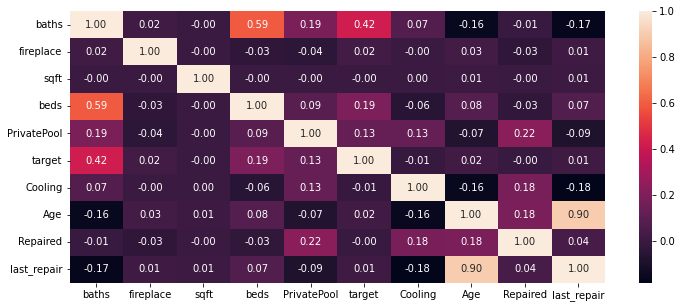

In [79]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(df_new_1.corr(), annot=True, fmt=".2f");

Для числовых признаков проверяем выбросы по методу 3 сигма. 

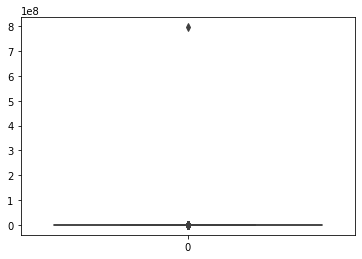

In [80]:
sns.boxplot(data=df_new_1['sqft']);

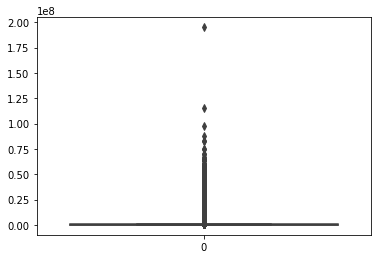

In [81]:
sns.boxplot(data=df_new_1['target']);

In [82]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned
#Производим очистку 
outliers, df_new_1_cleaned = outliers_z_score(df_new_1, 'sqft', True)
outliers, df_new_1_cleaned = outliers_z_score(df_new_1_cleaned, 'target', True)
outliers

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,PrivatePool,target,Heating,Cooling,Parking,Age,Repaired,last_repair
367,for sale,single-family,9.0,0,Fort Lauderdale,10330.0,7.0,FL,3,1,24000000.0,Forced air,1,Attached Garage,7.0,1,6.0
467,other,single-family,3.5,0,Chicago,3300.0,4.0,IL,,0,0.0,Central,0,Other,110.0,0,110.0
519,other,multi-family,2.0,0,Boston,1673.0,2.0,MA,,0,0.0,,0,,38.0,0,38.0
566,for sale,condo,6.0,0,Chicago,7587.0,4.0,IL,3+,1,15174000.0,Forced air,1,Attached Garage,4.0,0,4.0
1010,other,condo,7.0,0,Miami,8360.0,5.0,FL,,1,12250000.0,Other,1,Other,4.0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312097,for sale,condo,10.0,0,New York,3330.0,4.0,NY,,1,14950000.0,,0,,5.0,0,5.0
312692,for sale,condo,5.0,0,New York,5874.0,4.0,NY,3+,0,14995000.0,Forced air,0,,8.0,0,8.0
312815,other,single-family,2.0,0,Detroit,1258.0,4.0,MI,,0,1000.0,Forced air,0,Attached Garage,95.0,0,95.0
313341,other,condo,3.0,0,Miami Beach,4379.0,3.0,FL,,0,8900000.0,Forced air,1,Off Street,20.0,0,20.0


In [83]:
df_new_1_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
baths,210374.0,2.686166,1.230840,0.75,2.0,2.0,3.0,19.0
fireplace,210374.0,0.145902,0.353009,0.00,0.0,0.0,0.0,1.0
sqft,210374.0,2167.448853,1254.885077,248.00,1346.0,1854.0,2607.0,14418.0
beds,210374.0,3.123499,1.462933,0.00,2.0,3.0,4.0,19.0
PrivatePool,210374.0,0.152419,0.359427,0.00,0.0,0.0,0.0,1.0
target,210374.0,572306.120305,768031.443477,15750.00,219990.0,349000.0,599900.0,8595000.0
Cooling,210374.0,0.766378,0.423135,0.00,1.0,1.0,1.0,1.0
Age,210374.0,41.105536,32.641130,1.00,16.0,34.0,62.0,235.0
Repaired,210374.0,0.453687,0.497852,0.00,0.0,0.0,1.0,1.0
last_repair,210374.0,36.833088,30.512854,1.00,14.0,28.0,53.0,235.0


In [84]:
outliers, df_new_1_cleaned = outliers_z_score(df_new_1_cleaned, 'sqft', True)
outliers, df_new_1_cleaned = outliers_z_score(df_new_1_cleaned, 'target', True)
outliers, df_new_1_cleaned = outliers_z_score(df_new_1_cleaned, 'Age')
outliers, df_new_1_cleaned = outliers_z_score(df_new_1_cleaned, 'baths')
outliers.shape

(2135, 17)

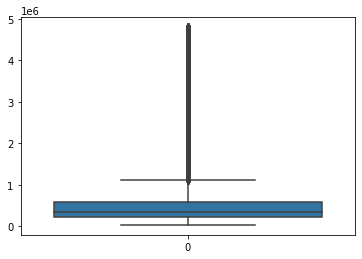

In [85]:
sns.boxplot(data=df_new_1_cleaned['target']);

In [86]:
df_new_1_cleaned.shape

(204429, 17)

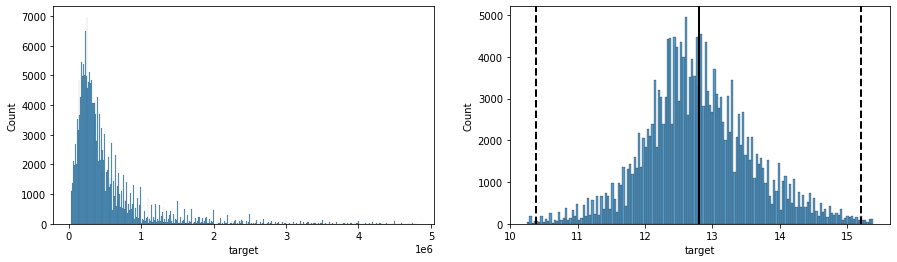

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df_new_1_cleaned, x='target', ax=axes[0]);
#Логарифмируем
log_price = np.log(df_new_1_cleaned['target'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

Строим корреляцию числовых признаков уже для очищенных данных

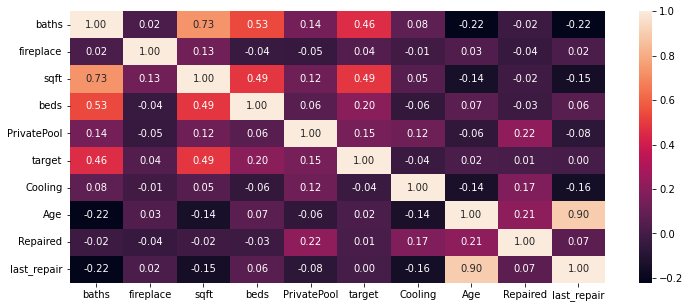

In [88]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(df_new_1_cleaned.corr(), annot=True, fmt=".2f");

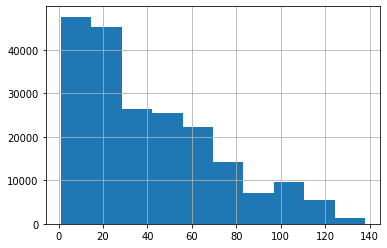

In [89]:
df_new_1_cleaned['Age'].hist();

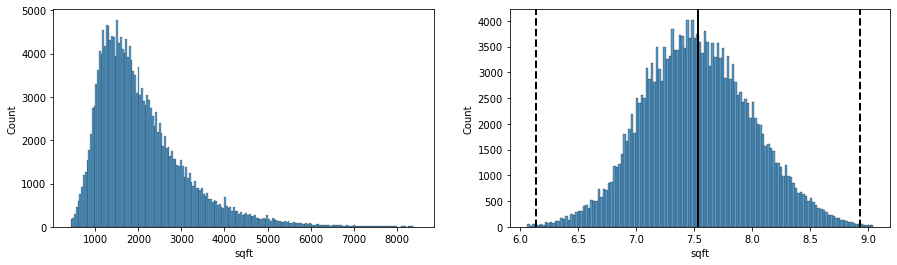

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df_new_1_cleaned, x='sqft', ax=axes[0]);
#Логарифмируем
log_price = np.log(df_new_1_cleaned['sqft'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

Видем сильную корреляцию между возрастом постройки и кол-вом лет с последнего проведенного ремонта. Удаляем один из признаков

In [91]:
df_new_1_cleaned = df_new_1_cleaned.drop(['last_repair'],axis=1)

In [92]:
##df_new_1_cleaned['sqft'] = np.log(df_new_1_cleaned['sqft'])
##df_new_1_cleaned['target'] = np.log(df_new_1_cleaned['target'])

Кодируем категориальные признаки методом OneHotEncoder

In [93]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()

In [94]:
df_new_1_cleaned = df_new_1_cleaned.reset_index(drop=True)

In [95]:
#Производим кодирование категориальных признаков
categorical_features_one = ['status','city','propertyType','stories','Heating','Parking','state']
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = onehot_encoder.fit_transform(df_new_1_cleaned[categorical_features_one]).toarray() 
column_names = onehot_encoder.get_feature_names_out(categorical_features_one)
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
dummies_data = pd.merge(df_new_1_cleaned, data_onehot, left_index=True, right_index=True)
dummies_data = dummies_data.drop(categorical_features_one, axis=1)

In [96]:
dummies_data.head()

,baths,fireplace,sqft,beds,PrivatePool,target,Cooling,Age,Repaired,status_Active,...,state_OR,state_PA,state_SC,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI
0,3.5,1,2900.0,4.0,0,418000.0,0,4.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0,1947.0,3.0,0,310000.0,0,4.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,0,3000.0,3.0,1,2895000.0,1,62.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0,3588.0,3.0,0,244900.0,1,53.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0,1930.0,3.0,0,311995.0,1,4.0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [97]:
dummies_data.isnull().sum().sum()

0

In [98]:
dummies_data.shape

(204429, 257)

Опрееляем целевую переменную 'target'. Делем выборку на train test в соотношении 80/20

In [99]:
#X - матрица наблюдений, y - столбец правильных ответов
X = dummies_data.drop('target', axis=1)
y = dummies_data['target']

In [100]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=40 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (163543, 256)
Test shape: (40886, 256)


Вводим функцию для определения метрик регрессии 

In [101]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('Train RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict))))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))
    print('Test RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict))))

Обучаем модель линейной регресии как наиболее простую для сравнения метрик с этой моделью

In [102]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.581
Train MAE: 203878.387
Train MAPE: 56.061
Train RMSE: 346996.113


Test R^2: 0.578
Test MAE: 206282.533
Test MAPE: 56.610
Test RMSE: 348381.119


Делаем аналогичное обучение модели линейной регресс с примененнием Minmax scale. Результат почти идентичный, отличается слабо.

In [103]:
from sklearn.preprocessing import MinMaxScaler

In [104]:
#Создаем объект для min-max нормализации
scaler = MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Инициализируем объект класса линейная регрессия
sgd_lr = linear_model.SGDRegressor(random_state=42)
#Обучаем модель - ищем параметры
sgd_lr.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = sgd_lr.predict(X_train_scaled)
y_test_pred = sgd_lr.predict(X_test_scaled)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.581
Train MAE: 203148.678
Train MAPE: 55.624
Train RMSE: 347225.642


Test R^2: 0.577
Test MAE: 205502.503
Test MAPE: 56.177
Test RMSE: 348579.770


Делаем аналогичное обучение модели линейной регресс предварительно переведя целевой признак в логарифмическую шкулу. Результат так же почти не отличается от обычной регрессии.

In [105]:
#создаем логарифмированный целевой признак цены
y_train_log = np.log(y_train)
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель предсказывать логарифм целевого признака
lr.fit(X_train, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(lr.predict(X_train))
y_test_pred = np.exp(lr.predict(X_test))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.532
Train MAE: 173784.809
Train MAPE: 35.051
Train RMSE: 366935.422


Test R^2: 0.504
Test MAE: 177050.009
Test MAPE: 35.517
Test RMSE: 377690.907


Обучаем модель и строим предсказание с помощью RandomForestRegressor. Результат значительно улучшается

In [106]:
from sklearn.ensemble import RandomForestRegressor

In [107]:
regr = RandomForestRegressor(n_estimators=150, max_depth=20,min_samples_leaf=2, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=150,
                      random_state=0)

In [108]:
#Делаем предсказание для каждой из выборок
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.866
Train MAE: 116942.345
Train MAPE: 34.982
Train RMSE: 196345.131


Test R^2: 0.723
Test MAE: 151874.837
Test MAPE: 39.449
Test RMSE: 282162.678


Подбираем оптимальны параметры для модели RandomForestRegressor. Находим лучшее предсказания с помощью данного метода.

In [109]:
from sklearn.model_selection import RandomizedSearchCV

In [110]:
param_distributions = {'n_estimators': list(range(100, 400, 5)),
              'min_samples_leaf': [2,5,7],
              'max_depth': list(np.linspace(5, 40, 8, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10,
    scoring='neg_root_mean_squared_error',
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
y_test_pred = random_search_forest.predict(X_test)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: user 7min 51s, sys: 9 s, total: 8min
Wall time: 5h 56min 47s
Train R^2: 0.866
Train MAE: 116797.839
Train MAPE: 34.879
Train RMSE: 196468.292


Test R^2: 0.724
Test MAE: 151705.435
Test MAPE: 39.363
Test RMSE: 281824.688


In [111]:
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 2, 'max_depth': 20}


In [109]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.7 MB/s eta 0:00:00


In [110]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.2.0


In [111]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 400)
  max_depth = trial.suggest_int('max_depth', 5, 30)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)

  # создаем модель
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.r2_score(y_train, model.predict(X_train))

  return score

In [114]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2023-06-07 06:56:43,309] A new study created in memory with name: RandomForestRegressor
[I 2023-06-07 07:09:36,322] Trial 0 finished with value: 0.7123120929821396 and parameters: {'n_estimators': 277, 'max_depth': 13, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7123120929821396.
[I 2023-06-07 07:15:43,718] Trial 1 finished with value: 0.5304001272122233 and parameters: {'n_estimators': 293, 'max_depth': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7123120929821396.
[I 2023-06-07 07:31:20,378] Trial 2 finished with value: 0.862962481202861 and parameters: {'n_estimators': 214, 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.862962481202861.
[I 2023-06-07 07:33:13,604] Trial 3 finished with value: 0.4802270925404216 and parameters: {'n_estimators': 109, 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.862962481202861.
[I 2023-06-07 07:43:15,778] Trial 4 finished with value: 0.6642938945415435 and parameters: {'n_estima

CPU times: user 1h 41min 36s, sys: 8.61 s, total: 1h 41min 44s
Wall time: 1h 42min 9s


In [115]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("r2_score на обучающем наборе: {:.3f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 134, 'max_depth': 29, 'min_samples_leaf': 2}
r2_score на обучающем наборе: 0.911


In [ ]:
regr_best = RandomForestRegressor(**random_search_forest.best_params_)
regr_best.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = regr_best.predict(X_train)
y_test_pred = regr_best.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

In [116]:
regr_best = RandomForestRegressor(**study.best_params)
regr_best.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = regr_best.predict(X_train)
y_test_pred = regr_best.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.911
Train MAE: 88019.812
Train MAPE: 24.844
Train RMSE: 160207.646


Test R^2: 0.737
Test MAE: 141380.129
Test MAPE: 34.015
Test RMSE: 275019.773


Обучаем модель CatBoostRegressor. Находим лучшее предсказания с помощью данного метода.

In [ ]:
!pip install catboost

In [114]:
from catboost import CatBoostRegressor

In [ ]:
cat = CatBoostRegressor()
grid = {'learning_rate': list(np.linspace(0.03, 0.21, 9, dtype=float)),
        'depth': [4, 6, 10, 14],
        'l2_leaf_reg': [1, 2, 3]}

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, plot=True)

In [ ]:
print("Наилучшие значения гиперпараметров: {}".format(grid_search_result['params']))

In [ ]:
model_cat = CatBoostRegressor(**grid_search_result['params']) 
model_cat.fit( 
	X_train, y_train, 
	eval_set=(X_test, y_test), 
) 

In [121]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [130]:
model_cat = CatBoostRegressor(iterations=6000, learning_rate=0.11, depth=10) 
model_cat.fit( 
	X_train, y_train, 
	eval_set=(X_test, y_test), 
)

0:	learn: 509178.6116170	test: 508909.8016661	best: 508909.8016661 (0)	total: 84.3ms	remaining: 8m 25s
1:	learn: 485873.1198514	test: 485723.9661379	best: 485723.9661379 (1)	total: 166ms	remaining: 8m 16s
2:	learn: 465357.1729881	test: 465162.0487995	best: 465162.0487995 (2)	total: 240ms	remaining: 8m
3:	learn: 448341.7780627	test: 448263.8193162	best: 448263.8193162 (3)	total: 319ms	remaining: 7m 58s
4:	learn: 433775.9499745	test: 433838.3397846	best: 433838.3397846 (4)	total: 551ms	remaining: 11m
5:	learn: 421063.1557359	test: 421154.9049437	best: 421154.9049437 (5)	total: 633ms	remaining: 10m 32s
6:	learn: 410118.6569543	test: 410249.6471214	best: 410249.6471214 (6)	total: 710ms	remaining: 10m 7s
7:	learn: 400212.3842848	test: 400424.2317594	best: 400424.2317594 (7)	total: 792ms	remaining: 9m 53s
8:	learn: 392057.0177579	test: 392433.8694085	best: 392433.8694085 (8)	total: 878ms	remaining: 9m 44s
9:	learn: 384950.8697015	test: 385699.4932125	best: 385699.4932125 (9)	total: 961ms	rem

In [124]:
cv = KFold(n_splits=5)
scores = cross_val_score(model_cat, X_train, y_train, scoring='r2', cv=cv)

0:	learn: 512078.9713864	total: 66.4ms	remaining: 3m 19s
1:	learn: 490528.8008382	total: 134ms	remaining: 3m 21s
2:	learn: 472506.4428273	total: 204ms	remaining: 3m 23s
3:	learn: 456329.8608509	total: 274ms	remaining: 3m 25s
4:	learn: 442129.0695046	total: 383ms	remaining: 3m 49s
5:	learn: 429742.1766374	total: 463ms	remaining: 3m 50s
6:	learn: 419031.5598976	total: 549ms	remaining: 3m 54s
7:	learn: 409188.4455793	total: 630ms	remaining: 3m 55s
8:	learn: 400234.7667156	total: 718ms	remaining: 3m 58s
9:	learn: 392852.6320636	total: 810ms	remaining: 4m 2s
10:	learn: 386104.3156178	total: 896ms	remaining: 4m 3s
11:	learn: 379889.4582296	total: 958ms	remaining: 3m 58s
12:	learn: 374688.0245568	total: 1.02s	remaining: 3m 54s
13:	learn: 369967.6329709	total: 1.11s	remaining: 3m 57s
14:	learn: 365641.5795812	total: 1.21s	remaining: 4m
15:	learn: 361878.2518477	total: 1.37s	remaining: 4m 15s
16:	learn: 358319.0941452	total: 1.49s	remaining: 4m 20s
17:	learn: 354914.5379148	total: 1.58s	remaini

KeyboardInterrupt: 

In [131]:
#Делаем предсказание для каждой из выборок
y_train_pred = model_cat.predict(X_train)
y_test_pred = model_cat.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.931
Train MAE: 83694.825
Train MAPE: 21.951
Train RMSE: 141327.362


Test R^2: 0.774
Test MAE: 129783.570
Test MAPE: 29.192
Test RMSE: 255063.596


Смотрим параметры модели которые в наибольшей степени влияют на результат.

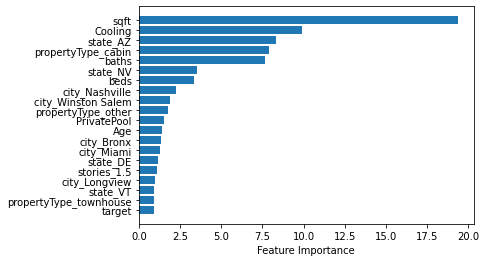

In [129]:
sorted_feature_importance = model_cat.get_feature_importance().argsort( 
	)[-20:] 
plt.barh( 
	dummies_data.columns[sorted_feature_importance], 
	model_cat.feature_importances_[sorted_feature_importance] 
) 
plt.xlabel("Feature Importance") 
plt.show()

Смотрим разброс ошибки, пытаемся улучшить предсказание. Проанализировав выпадающие значения.

In [ ]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [ ]:
y_train_errors = pd.DataFrame({'Train errors': y_train_errors})
y_test_errors = pd.DataFrame({'Test errors': y_test_errors})

In [ ]:
predict_df_Train = pd.concat([X_train, y_train_errors], axis=1)
predict_df_Test = pd.concat([X_test, y_test_errors], axis=1)

In [ ]:
outliers_er_t, predict_df_error = outliers_z_score(predict_df_Test, 'Test errors')
er_t = outliers_er_t.sort_values('Test errors',ascending=0).head(10).index

In [ ]:
outliers_er_t.sort_values('Test errors',ascending=0).head(10)

In [ ]:
df_new_1_cleaned.loc[er_t]

Сереализуем лучшую модель и метод OneHotEncoder для последующей реализации предсказания через запрос на сервере

In [117]:
import pickle

In [127]:
with open('Estate_cat.pkl', 'wb') as output:
    pickle.dump(model_cat, output)

In [ ]:
with open('Estate_rf.pkl', 'wb') as output:
    pickle.dump(regr_best, output)

In [132]:
with open('one_hot_enc.pkl', 'wb') as output:
    pickle.dump(onehot_encoder, output)

In [111]:
df_new_1_cleaned.iloc[25].to_json()

'{"status":"for sale","propertyType":"single-family","baths":2.0,"fireplace":0,"city":"Miami","sqft":1396.0,"beds":3.0,"state":"FL","stories":"","PrivatePool":0,"target":495000.0,"Heating":"Forced air","Cooling":1,"Parking":"Other","Age":69.0,"Repaired":1}'